![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [281]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [283]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


In [285]:
cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cc_apps = cc_apps[~cc_apps[cols].isin(['?']).any(axis=1)]

In [287]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    object 
 1   1       659 non-null    object 
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    object 
 9   9       659 non-null    object 
 10  10      659 non-null    int64  
 11  11      659 non-null    object 
 12  12      659 non-null    int64  
 13  13      659 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 77.2+ KB


In [289]:
df_encoded = pd.get_dummies(cc_apps, columns=[0, 3, 4, 5, 6, 8, 9, 11], dtype=int)


In [291]:
df_encoded.head()

,1,2,7,10,12,13,0_a,0_b,3_l,3_u,...,6_o,6_v,6_z,8_f,8_t,9_f,9_t,11_g,11_p,11_s
0,30.83,0.000,1.25,1,0,+,0,1,0,1,...,0,1,0,0,1,0,1,1,0,0
1,58.67,4.460,3.04,6,560,+,1,0,0,1,...,0,0,0,0,1,0,1,1,0,0
2,24.50,0.500,1.50,0,824,+,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
3,27.83,1.540,3.75,5,3,+,0,1,0,1,...,0,1,0,0,1,0,1,1,0,0
4,20.17,5.625,1.71,0,0,+,0,1,0,1,...,0,1,0,0,1,1,0,0,0,1


In [293]:
# Drop target columns to form features X
X = df_encoded.drop([13], axis=1)

# Select target columns
y = df_encoded[13].map({'+': 1, '-': 0})

print(X.head())
print(y.head())

       1      2     7  10   12  0_a  0_b  3_l  3_u  3_y  ...  6_o  6_v  6_z  \
0  30.83  0.000  1.25   1    0    0    1    0    1    0  ...    0    1    0   
1  58.67  4.460  3.04   6  560    1    0    0    1    0  ...    0    0    0   
2  24.50  0.500  1.50   0  824    1    0    0    1    0  ...    0    0    0   
3  27.83  1.540  3.75   5    3    0    1    0    1    0  ...    0    1    0   
4  20.17  5.625  1.71   0    0    0    1    0    1    0  ...    0    1    0   

   8_f  8_t  9_f  9_t  11_g  11_p  11_s  
0    0    1    0    1     1     0     0  
1    0    1    0    1     1     0     0  
2    0    1    1    0     1     0     0  
3    0    1    0    1     1     0     0  
4    0    1    1    0     0     0     1  

[5 rows x 43 columns]
0    1
1    1
2    1
3    1
4    1
Name: 13, dtype: int64


In [295]:
# Convert all column names to strings
X.columns = X.columns.astype(str)
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [297]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],              
    'penalty': ['l2'],                    
    'solver': ['liblinear']               
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Setup GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit on training data
grid_search.fit(X_train, y_train) 

# Best parameters
print("✅ Best Parameters:", grid_search.best_params_)

# Evaluate on test data
y_pred = grid_search.predict(X_test)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

✅ Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85        75
           1       0.77      0.88      0.82        57

    accuracy                           0.83       132
   macro avg       0.83      0.84      0.83       132
weighted avg       0.84      0.83      0.83       132



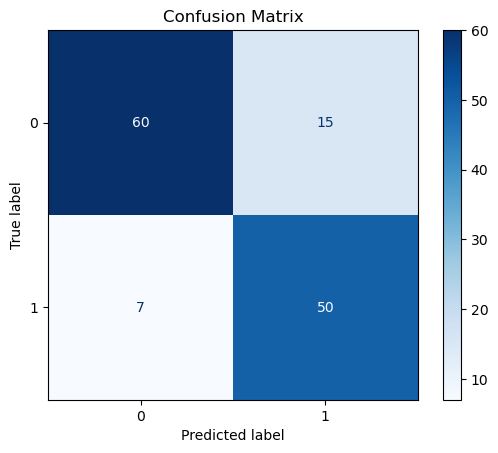

In [299]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [301]:
best_score = grid_search.best_score_

print(f"✅ Best CV Accuracy Score: {best_score:.4f}")

✅ Best CV Accuracy Score: 0.8803
